In [32]:
import sys
print("Chemin de l'exécutable Python :", sys.executable)
print("Version de Python :", sys.version)

Chemin de l'exécutable Python : c:\Users\micha\AppData\Local\Programs\Python\Python311\python.exe
Version de Python : 3.11.1 (tags/v3.11.1:a7a450f, Dec  6 2022, 19:58:39) [MSC v.1934 64 bit (AMD64)]


In [1]:
%matplotlib inline
# Load all necessary packages
# import sys
# sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


1. - Preprocess the data
- binarize Age. 
- Split the data into train, validation, test sets
- train a classifier
- Measure the performance of the classifier on the test set. 

In [2]:
import random
random_seed = 42
random.seed(random_seed)  
np.random.seed(random_seed)  
# A -------------------------------- Import dataaset and binarize age ----------------------------------------------

# Import dataset
dataset_orig = AdultDataset()

# Convert to dataframe to visualize it
data, _ = dataset_orig.convert_to_dataframe()

# Copy only to binarize age (Threshold = 40 years)
binarised = data.copy()
binarised['age'] = binarised['age'].apply(lambda x: 0 if x <= 40 else 1) # 1 if greater than 40

# B ----------------------------- Split into train, validation and test --------------------------------------------

# Separate into train (70%) and validation+test (30%)

dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
# Separate into validation and test

dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)
# C ----------------------------- Train a classifier --------------------------------------------

# Define first the target and our features (Target is income-per-year (1 --> >50 k))

# 1. Normalise training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)  # Features
y_train = dataset_orig_train.labels.ravel()  # Target (income-per-year)
w_train = dataset_orig_train.instance_weights.ravel()  

# 2. Train the classifier
the_classifier = LogisticRegression()
the_classifier.fit(X_train, y_train, sample_weight=w_train) 

# 3. Predictions
y_train_pred = the_classifier.predict(X_train)  # Predict labels on training set

# Positive class (Here, >50K)
pos_ind = np.where(the_classifier.classes_ == dataset_orig_train.favorable_label)[0][0] 

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred  # Replace labels by the predictions

# D ----------------------------- Performances on the test set --------------------------------------------
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

# Normalise as in the training and extract labels of test set
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels

# Predict probability for class
dataset_orig_test_pred.scores = the_classifier.predict_proba(X_test)[:, pos_ind].reshape(-1, 1)

print("Test set scores (first 10 predictions):")
print(dataset_orig_test_pred.scores[:10])

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Convert scores to binary predictions (threshold = 0.5)
y_test_pred = (dataset_orig_test_pred.scores > 0.5).astype(int)

# Compute main metrics
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Test Precision: {precision_score(y_test, y_test_pred)}")
print(f"Test Recall: {recall_score(y_test, y_test_pred)}")


Test set scores (first 10 predictions):
[[0.05110014]
 [0.01196516]
 [0.05237648]
 [0.64457542]
 [0.61894245]
 [0.48253575]
 [0.01588735]
 [0.00462869]
 [0.00106118]
 [0.26590193]]
Test Accuracy: 0.8438974056603774
Test Precision: 0.7225392296718973
Test Recall: 0.6019013666072489


2. - Assess the group fairness of the classifier, assuming the protected attributes are Age, Sex. 
- apply a technique to ensure the classifier is fair.

In [3]:
random_seed = 42
random.seed(random_seed) 
np.random.seed(random_seed)

# A -------- Assess the group fairness of the classifier, assuming the protected attributes are Age, Sex ------------ 

privileged_groups = [{'sex': 1}]  # Men are priviledged
unprivileged_groups = [{'sex': 0}]  

test_predicted = dataset_orig_test.copy()
test_predicted.labels = y_test_pred  # Prédictions du classifier

print("\nInstance weights before reweighting:")
print(test_predicted.instance_weights[:10])  
# Compute fairness of the classifier (test set)
metric_test_classifier = BinaryLabelDatasetMetric(test_predicted, 
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups)

display(Markdown("#### Test set fairness metrics (classifier):"))
print("Statistical Parity Difference (classifier):", metric_test_classifier.statistical_parity_difference())

# B ---------------- apply a technique to ensure the classifier is fair  ----------------------------------------------

RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)
dataset_train_transf = RW.fit_transform(dataset_orig_train)

print("\nInstance weights after reweighting:")
print(dataset_train_transf.instance_weights[:10])  

metric_transf_train = BinaryLabelDatasetMetric(dataset_train_transf, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
print("\n")
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups (Sex):")
print(metric_transf_train.statistical_parity_difference())

# C ------------------------- Train our 'fair classifier' on the new dataset ----------------------------------------------
# Normalise transformed data
X_train_rw = scale_orig.fit_transform(dataset_train_transf.features)  # Features corrigées
y_train_rw = dataset_train_transf.labels.ravel()  # Labels corrigés
w_train_rw = dataset_train_transf.instance_weights.ravel()  # Poids ajustés

# Train model again with transformed data
fair_classifier = LogisticRegression(random_state=random_seed)
fair_classifier.fit(X_train_rw, y_train_rw, sample_weight=w_train_rw)

# Predictions 
y_train_pred_fair = fair_classifier.predict(X_train_rw)

dataset_train_transf_pred = dataset_train_transf.copy()
dataset_train_transf_pred.labels = y_train_pred_fair

# D ------------------------------- Performances on test set (Fair classifier) --------------------------------------
X_test_rw = scale_orig.transform(dataset_orig_test.features)
y_test = dataset_orig_test.labels

# Predictions with the fair classifier
dataset_orig_test_pred_fair = dataset_orig_test.copy()
y_test_pred_fair = fair_classifier.predict(X_test_rw)

dataset_orig_test_pred_fair.scores = fair_classifier.predict_proba(X_test_rw)[:, pos_ind].reshape(-1, 1)

# Display scores for 10 first instances
print("\nTest set scores (first 10 predictions) for the fair classifier:")
print(dataset_orig_test_pred_fair.scores[:10])

y_test_pred_fair_bin = (dataset_orig_test_pred_fair.scores > 0.5).astype(int)

# Main metrics
print("Main classifier :\n")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Test Precision: {precision_score(y_test, y_test_pred)}")
print(f"Test Recall: {recall_score(y_test, y_test_pred)}")
print("\nFair classifier :\n")
print(f"Fair Classifier - Test Accuracy: {accuracy_score(y_test, y_test_pred_fair_bin)}")
print(f"Fair Classifier - Test Precision: {precision_score(y_test, y_test_pred_fair_bin)}")
print(f"Fair Classifier - Test Recall: {recall_score(y_test, y_test_pred_fair_bin)}")



Instance weights before reweighting:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


#### Test set fairness metrics (classifier):

Statistical Parity Difference (classifier): -0.17871986305566923

Instance weights after reweighting:
[0.8457202  1.09594426 0.78982139 1.09594426 1.09594426 0.78982139
 0.78982139 1.09594426 0.8457202  1.09594426]




#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups (Sex):
5.551115123125783e-17

Test set scores (first 10 predictions) for the fair classifier:
[[0.0344237 ]
 [0.00917653]
 [0.12897345]
 [0.56631903]
 [0.54080346]
 [0.41756688]
 [0.03856527]
 [0.00350017]
 [0.0005973 ]
 [0.20684067]]
Main classifier :

Test Accuracy: 0.8438974056603774
Test Precision: 0.7225392296718973
Test Recall: 0.6019013666072489

Fair classifier :

Fair Classifier - Test Accuracy: 0.8365271226415094
Fair Classifier - Test Precision: 0.7235202492211839
Fair Classifier - Test Recall: 0.5519904931669638


3 - Cross tabulation showing the nb of persons for each combinations of Age and Sexe

In [4]:
import pandas as pd

cross_tab = pd.crosstab(index=binarised['age'],  # Age (binarisé : 0=Jeune, 1=Âgé)
                        columns=binarised['sex'],  # Sex (0=Femme, 1=Homme)
                        rownames=['Age'],
                        colnames=['Sex'])

cross_tab['Total'] = cross_tab.sum(axis=1)  # Totaux des lignes
cross_tab.loc['Total'] = cross_tab.sum(axis=0)  # Totaux des colonnes

# Afficher la cross-tabulation
print("\nCross-tabulation of Age and Sex:")
cross_tabulation_frame = pd.DataFrame(cross_tab)

print(f"There are {cross_tab[0.0][0]} young females (Age=0, Sex=0.0).")
print(f"There are {cross_tab[1.0][0]} young males (Age=0, Sex=1.0).")
print(f"There are {cross_tab[0.0][1]} aged females (Age=1, Sex=0.0).")
print(f"There are {cross_tab[1.0][1]} aged males (Age=1, Sex=1.0).")

print(f"Total young people (Age=0): {cross_tab['Total'][0]}.")
print(f"Total aged people (Age=1): {cross_tab['Total'][1]}.")

print(f"Total females (Sex=0.0): {cross_tab[0.0]['Total']}.")
print(f"Total males (Sex=1.0): {cross_tab[1.0]['Total']}.")
print(f"Grand total: {cross_tab['Total']['Total']}.")

cross_tabulation_frame


Cross-tabulation of Age and Sex:
There are 9248 young females (Age=0, Sex=0.0).
There are 17303 young males (Age=0, Sex=1.0).
There are 5447 aged females (Age=1, Sex=0.0).
There are 13224 aged males (Age=1, Sex=1.0).
Total young people (Age=0): 26551.
Total aged people (Age=1): 18671.
Total females (Sex=0.0): 14695.
Total males (Sex=1.0): 30527.
Grand total: 45222.


Sex,0.0,1.0,Total
Age,,,
0,9248,17303,26551
1,5447,13224,18671
Total,14695,30527,45222


B - Local differential privacy on age and sex and generation of a new noisy dataset

In [6]:
import random

def rand_resp(x, p=0.75, q=0.75):
    toss = random.random()
    if x == 0:
        y = 0 if toss <= q else 1
    else:
        y = 1 if toss <= p else 0
    return y

In [ ]:

for epsilon in [0.1, 0.5, 1.0, 2.0]:
    p, q = np.exp(epsilon) / (1 + np.exp(epsilon)), np.exp(epsilon) / (1 + np.exp(epsilon))
    
    binarised_private = binarised.copy()
    # Add the noise to Age and Sex
    binarised_private['age'] = binarised['age'].apply(lambda x: rand_resp(x, p, q))
    binarised_private['sex'] = binarised['sex'].apply(lambda x: rand_resp(x, p, q))


Create a new noisy dataset for these attributes
and
Visualize the results (Test with various epsilon and quantify the divergence for each value) 

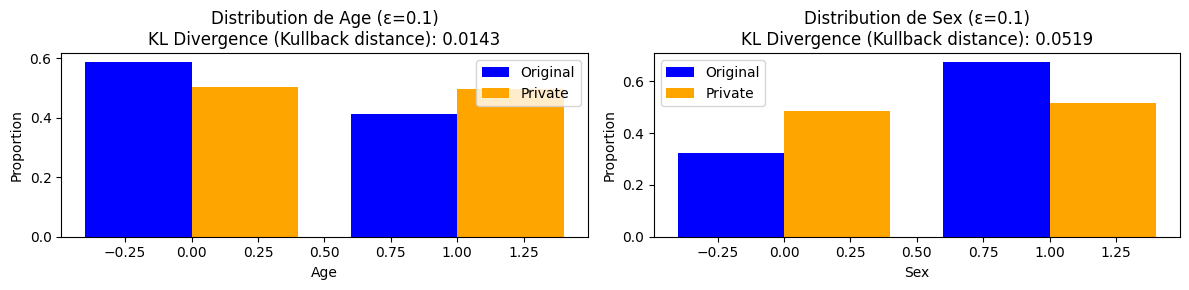

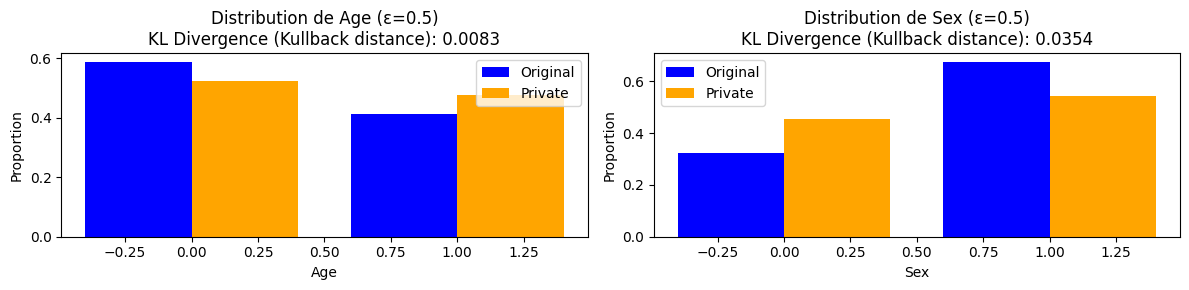

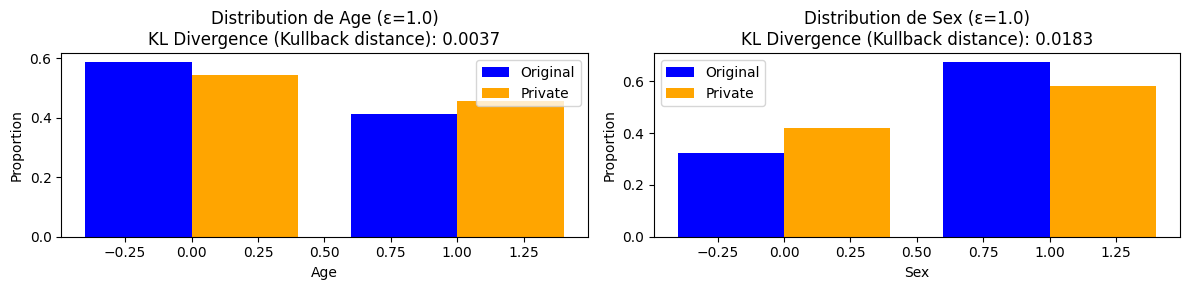

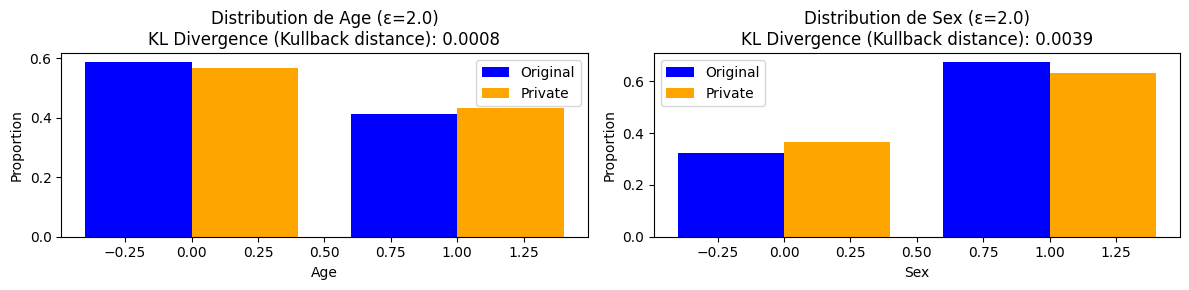

In [29]:
import matplotlib.pyplot as plt
import numpy as np

epsilon_values = [0.1, 0.5, 1.0, 2.0]
from scipy.stats import entropy

def kl_divergence(original_dist, private_dist):
    """
    Compute the kullback distance between the two distributions. 
    """
    # Normaliser les distributions (pour éviter les problèmes)
    original_dist = original_dist / original_dist.sum()
    private_dist = private_dist / private_dist.sum()
    
    # Calculer la divergence KL
    return entropy(original_dist, private_dist)

# Fonction pour tracer les histogrammes
def plot_distribution(original_data, private_data, epsilon):
    attributes = ['age', 'sex']  # Liste des attributs à comparer

    # Créer une figure avec deux subplots
    plt.figure(figsize=(12, 3))  # Taille ajustée pour deux subplots

    for i, att in enumerate(attributes, start=1):  # Boucle avec index pour subplot
        original_dist = original_data[att].value_counts(normalize=True)
        private_dist = private_data[att].value_counts(normalize=True)
        
        kl_div = kl_divergence(original_dist, private_dist)

        # Ajouter le subplot
        plt.subplot(1, 2, i)  # 1 ligne, 2 colonnes, ième subplot
        plt.bar(original_dist.index - 0.2, original_dist, width=0.4, label='Original', color='blue')
        plt.bar(private_dist.index + 0.2, private_dist, width=0.4, label='Private', color='orange')

        # Ajouter des labels et un titre
        plt.xlabel(att.capitalize())
        plt.ylabel('Proportion')
        plt.title(f'Distribution de {att.capitalize()} (ε={epsilon})\nKL Divergence (Kullback distance): {kl_div:.4f}')
        plt.legend()

    # Afficher les subplots côte à côte
    plt.tight_layout()
    plt.show()

# Boucle pour chaque epsilon
for epsilon in epsilon_values:
    p, q = np.exp(epsilon) / (1 + np.exp(epsilon)), np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # Copy of the noisy dataset
    binarised_private = binarised.copy()
    binarised_private['age'] = binarised['age'].apply(lambda x: rand_resp(x, p, q))
    binarised_private['sex'] = binarised['sex'].apply(lambda x: rand_resp(x, p, q))
    
    # Plot the histograms with metric of divergence
    plot_distribution(binarised, binarised_private, epsilon)

- Cross tabulation for private dataset

In [31]:
# Cross-tabulation sur les données originales
original_crosstab = pd.crosstab(binarised['age'], binarised['sex'], margins=True)

# Cross-tabulation sur les données privées
private_crosstab = pd.crosstab(binarised_private['age'], binarised_private['sex'], margins=True)

# Affichage des tables
print("Original Data Cross-tabulation:")
pd.DataFrame(original_crosstab)

Original Data Cross-tabulation:


sex,0.0,1.0,All
age,,,
0,9248,17303,26551
1,5447,13224,18671
All,14695,30527,45222


In [32]:
print("\nPrivate Data Cross-tabulation:")
pd.DataFrame(private_crosstab)


Private Data Cross-tabulation:


sex,0,1,All
age,,,
0,9762,15912,25674
1,6847,12701,19548
All,16609,28613,45222
